In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("..")
# this is the convenience function
from autokoopman import auto_koopman

In [2]:
import sympy as sp
import autokoopman.core.system as asys

class Pendulum(asys.SymbolicContinuousSystem):
    
    def __init__(self, g=9.81, l=1.0, beta=0.0):
        theta, thetadot = sp.symbols("theta thetadot")
        xdot = [thetadot, -g / l * sp.sin(theta) - 2 * beta * thetadot]
        super(Pendulum, self).__init__(
            (theta, thetadot), xdot
        )

In [3]:
dt = 0.02
pnd = Pendulum()
training_data = pnd.solve_ivps(
    initial_states=np.random.uniform(low=(-2.5, -1), high=(2.5, 1), size=(1000, 2)),
    tspan=[0.0, 1],
    sampling_period=dt
)

test_ivs = np.random.uniform(low=(-2.5, -1), high=(2.5, 1), size=(20, 2))
test_data = pnd.solve_ivps(
    initial_states=test_ivs,
    tspan=[0.0, 1],
    sampling_period=dt
)

In [4]:
import autokoopman.estimator.deepkoopman as dk

koop = dk.DeepKoopman(
    state_dim=len(training_data.state_names), 
    input_dim=0, 
    hidden_dim=50, 
    max_iter=6000,
    lr=1e-3, 
    hidden_enc_dim=256,
    num_hidden_layers=2,  
    metric_loss_weight=1e-2, 
    pred_loss_weight=1e-2, 
    validation_data=test_data
)

DeepKoopman is using torch device 'cuda:0'


In [5]:
# do training
koop.fit(training_data)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [31:30<00:00,  3.17it/s]


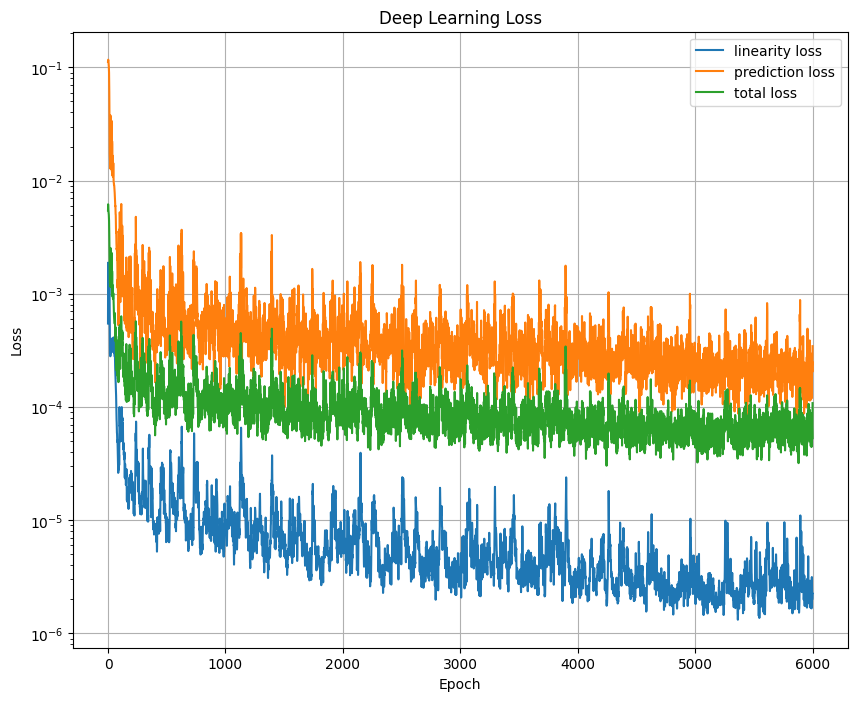

In [6]:
plt.figure(figsize=(10, 8))
plt.plot(koop.loss_hist['validation_lin_loss'], label="linearity loss")
plt.plot(koop.loss_hist['validation_pred_loss'], label="prediction loss")
plt.plot(koop.loss_hist['validation_total_loss'], label="total loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Deep Learning Loss")
plt.legend()
plt.grid()
plt.show()

In [11]:
# solve for test trajectories
fit_data = koop.model.solve_ivps(test_ivs, tspan=[0.0, 1], sampling_period=dt)

Text(0.5, 1.0, 'pendulum Deep Koopman')

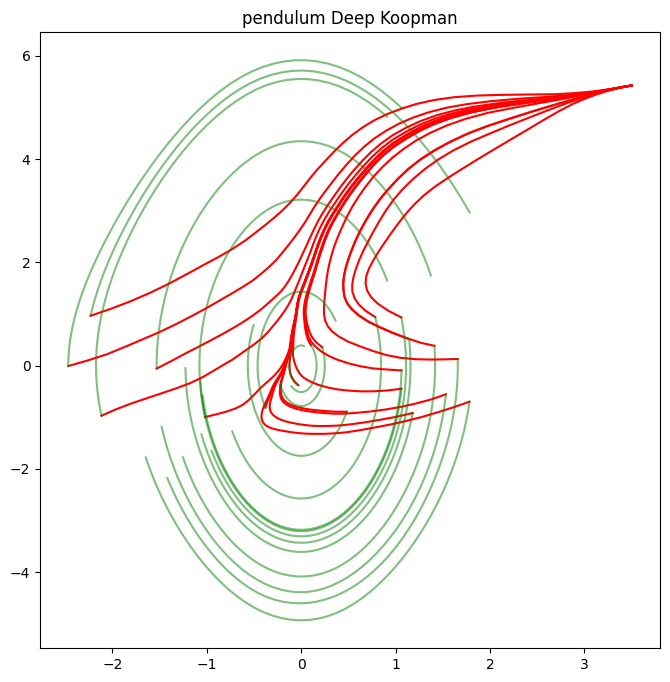

In [12]:
plt.figure(figsize=(8, 8))
# for t in training_data:
#     plt.plot(*t.states.T, 'gray', alpha=0.3)
for t, tt in zip(fit_data, test_data):
    plt.plot(*t.states.T, 'r')
    plt.plot(*tt.states.T, 'g', alpha=0.5)
    
plt.title("pendulum Deep Koopman")